In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import category_encoders as ce
import hvplot.pandas
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer,OneHotEncoder
from sklearn.metrics import confusion_matrix,f1_score, make_scorer, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV,GridSearchCV,cross_val_score
from itertools import cycle
from sklearn import preprocessing

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

- Besides from the perfect correlation of Grade column with itself, columns like int_rate which is interest rate, out_prncp_inv which is remaining outstanding principal, etc. have high positive correlation with the Grade column and these are quite true as higher the interest rate, higher it is harder for a borrower to pay back a loan.

- However, columns like out_prncp_inv, out_prncp, total_rec_int, total_rec_late_fee, inq_last_6mths and revol_util are bound to be higher when a borrower doesn't pay back a loan and thus doesn't carry much significance. So, the column of interest after int_rate could be the dti which is the Debt to Income ratio which understandably will affect if a borrower can pay back a loan or not.

- Also, columns like recoveries, total_rev_hi_lim, etc. have negative correlation with the Grade column as a borrower who has paid back money is more likely to repay the loan.

- The interest rate is also highly positively correlated with the debt to income ratio. The density of interest rates follow kind of a Gaussian distribution with more density on interest rates between 12%-18%.

- Seeing the number of joint applicants in comparison to the the total applicants, it isn't significant enough to conclude that the loan taken by all Joint applicants are paid back.

- The annual income of the applicant has high positive correlation with the amount of loan they have taken.

- There are more number of loans taken amount from the same states where there are more number of defaulted risk. This is why the state cannot be taken as a major feature for knowing if a loan will be defaulted or not.

## Data Preprocessing

In [264]:
def length_compute(df):
  df["credit_history_length"] = (df['issue_d_year'] - df['earliest_cr_line_year']) * 12 + (df['issue_d_month'] - df['earliest_cr_line_month'])
  df["time_since_last_payment"] = -(df['issue_d_year'] - df['last_pymnt_d_year']) * 12 + (df['issue_d_month'] - df['last_pymnt_d_month'])
  df["time_since_last_credit_pull"] = -(df['issue_d_year'] - df['last_credit_pull_d_year']) * 12 + (df['issue_d_month'] - df['last_credit_pull_d_month'])
  df["loan_age_at_last_payment"] = (df['last_pymnt_d_year'] - df['issue_d_year']) * 12 + (df['last_pymnt_d_month'] - df['issue_d_month'])
  return df

In [291]:
def featureEnginering(df, train= False):
  df = df.replace({"10+ years": 10, "9 years": 9,"8 years": 8,"7 years": 7,
                                  "6 years": 6,"5 years": 5,"4 years": 4,"3 years": 3,
                                  "2 years": 2,"1 year": 1, "< 1 year": 0})

  df = df.drop(['verification_status', 'pymnt_plan', 'addr_state',
           'initial_list_status', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag',
           # drop columns not issued to borrowers
           'funded_amnt_inv', 'total_pymnt_inv', 'out_prncp_inv', 'funded_amnt_inv', 'funded_amnt'], axis=1)

  # label_encoding
  if train == True:
    columnsTolabel = ['grade','application_type','term','loan_status']
  else:
    columnsTolabel = ['application_type' , 'term','loan_status']

  for column in columnsTolabel:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])

  # onehot encoding
  encoder = OneHotEncoder(sparse=False)
  columnsToOnehot = ['purpose','home_ownership']
  for column in columnsToOnehot:
    encoded = encoder.fit_transform(df[[column]])
    encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())
    df = pd.concat([df, encoded], axis=1)
    df.drop(column, axis=1, inplace=True)

  # Date-Time Features
  df = length_compute(df)

  return df


## Data Preparation

### Data preparation

In [ ]:
# import the data
train = pd.read_csv('/content/drive/MyDrive/184702-tu-ml-ws-23-loan/loan-10k.lrn.csv')
test =  pd.read_csv('/content/drive/MyDrive/184702-tu-ml-ws-23-loan/loan-10k.tes.csv')

train = featureEnginering(train,True)
test = featureEnginering(test, False)

feature_names = list(
    filter(lambda x: x not in ['grade', 'ID'], train.columns))

X = train[feature_names]
y = train['grade']

In [308]:
# train test split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=True, stratify=train.grade)

sc=StandardScaler()
scaler = sc.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Defined Funcitons

In [315]:
def prediction_test(test, model,  scale =True):
  # save model
  joblib.dump(model, 'model.pkl')
  loaded_model = joblib.load('model.pkl')

  prediction = test[['ID']]
  test = test.drop('ID', axis=1)
  if scale:
    test_scaled = scaler.transform(test)
    y_pred = loaded_model.predict(test_scaled)
  elif scale == False:
    y_pred = loaded_model.predict(test)

  prediction = pd.concat([prediction, pd.DataFrame(y_pred, columns=['prediction'])], axis=1)
  mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G'}
  prediction['grade'] = prediction['prediction'].map(mapping)
  prediction.drop(['prediction'], axis=1, inplace=True)

  return prediction

In [295]:
def optimize_parameters(model, param_grids, other_params, X_train, y_train):
    # Parameters fine tunning
    GridSearch = pd.DataFrame(columns=['model', 'best_params', 'f1_weighted'])
    estimator = model(**other_params)
    for param in param_grids:
        gsearch = GridSearchCV(estimator, param_grid=param, scoring='f1_weighted', cv=3, verbose = 1)
        gsearch.fit(X_train, y_train)
        GridSearch = GridSearch.append({'model': str(model),
                                  'best_params': gsearch.best_params_,
                                  'f1_weighted': gsearch.best_score_},
                                  ignore_index=True)
        # update best params
        scores = gsearch.best_params_
        for key in scores.keys():
          other_params[key] = scores[key]

    return GridSearch

In [296]:
def get_metrics(report):
  macro_f1_score = float(report_gbm.split('\n')[-3].split()[4])
  weighted_scores = report.split('\n')[-2].split()[2:]
  weighted_f1_score = float(weighted_scores[2])

  f1_score_GradeD = float(report.split("\n")[-9].split()[2:][1])
  f1_score_GradeE = float(report.split("\n")[-8].split()[2:][1])
  f1_score_GradeF = float(report.split("\n")[-7].split()[2:][1])

  return macro_f1_score, weighted_f1_score, f1_score_GradeD, f1_score_GradeE, f1_score_GradeF

## Model Prediction

In [ ]:
# The impact on scaling
models = [LGBMClassifier(),
          XGBClassifier(),
          MLPClassifier() ]

result = dict()
for model in models:
    model_name1 = str(model).split('(')[0][:-10]
    scores1 = cross_val_score(model, X = X_train, y=y_train, verbose=0, cv = 5, scoring='f1_weighted')
    result[model_name1] = scores1

    model_name2 = str(model).split('(')[0][:-10]+ '_Xscaled'
    scores2 = cross_val_score(model, X = X_train_scaled, y=y_train, verbose=0, cv = 5, scoring='f1_weighted')
    result[model_name2] = scores2

result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]

In [299]:
result

,LGBM,LGBM_Xscaled,XGB,XGB_Xscaled,MLP,MLP_Xscaled
cv1,0.989468,0.989484,0.988880,0.988880,0.304006,0.822001
cv2,0.981581,0.982886,0.975452,0.975452,0.322019,0.838477
cv3,0.994494,0.995097,0.989428,0.989428,0.401062,0.851210
cv4,0.990330,0.989654,0.983176,0.983176,0.327703,0.833560
cv5,0.992934,0.991714,0.988970,0.988970,0.352843,0.823676


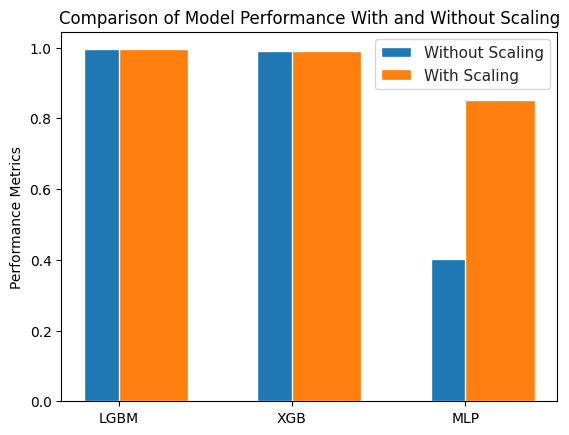

In [300]:
# plot the scaling result
model_unscaled = {'LGBM': 0.994494, 'XGB': 0.989428, 'MLP': 0.401062}
model_scaled = {'LGBM': 0.995097, 'XGB': 0.989428, 'MLP': 0.851210}

result_plot = pd.DataFrame({'Model': model_unscaled.keys(),
                   'Model without Scaling': model_unscaled.values(),
                   'Model with Scaling': model_scaled.values()})

import seaborn as sns
fig, ax = plt.subplots()
sns.set(style="white")
x = range(len(model_unscaled))
ax.bar(x, model_unscaled.values(), width=0.4, align='center', label='Without Scaling')
ax.bar(x, model_scaled.values(), width=0.4, align='edge', label='With Scaling')
plt.xticks(x, model_unscaled.keys())
plt.ylabel('Performance Metrics')
plt.title('Comparison of Model Performance With and Without Scaling')
plt.legend()
plt.show()

### Model1 : LGBMClassifier

In [ ]:
# LGBMClassifier
gbm = LGBMClassifier(class_weight='balanced')
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)])
y_pred_gbm = gbm.predict(X_test)
#report
report_gbm = classification_report(y_test, y_pred_gbm)
macro_f1_score_gbm, f1_score_gbm, f1_GradeD_gbm, f1_GradeE_gbm, f1_GradeF_gbm = get_metrics(report_gbm)

In [333]:
print(report_gbm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00       576
           2       1.00      1.00      1.00       598
           3       0.98      0.99      0.99       290
           4       0.97      0.94      0.96       124
           5       0.89      0.86      0.88        37
           6       0.82      0.82      0.82        11

    accuracy                           0.99      2000
   macro avg       0.95      0.94      0.95      2000
weighted avg       0.99      0.99      0.99      2000



In [ ]:
# LGBMClassifier
gbm_ = LGBMClassifier(class_weight='balanced',learning_rate=0.01, n_estimators=1000, num_leaves=20, reg_alpha=0, reg_lambda=0.5)
gbm_.fit(X_train, y_train, eval_set=[(X_test, y_test)])
y_pred_gbm = gbm_.predict(X_test)
#report
report_gbm = classification_report(y_test, y_pred_gbm)
macro_f1_score_gbm, f1_score_gbm, f1_GradeD_gbm, f1_GradeE_gbm, f1_GradeF_gbm = get_metrics(report_gbm)

In [322]:
print(report_gbm)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       364
           1       1.00      1.00      1.00       576
           2       0.99      1.00      1.00       598
           3       0.98      0.99      0.98       290
           4       0.96      0.94      0.95       124
           5       0.89      0.84      0.86        37
           6       0.82      0.82      0.82        11

    accuracy                           0.99      2000
   macro avg       0.95      0.94      0.94      2000
weighted avg       0.99      0.99      0.99      2000



In [372]:
confusion_matrix(y_test, y_pred_gbm)

array([[363,   1,   0,   0,   0,   0,   0],
       [  0, 575,   1,   0,   0,   0,   0],
       [  0,   0, 597,   1,   0,   0,   0],
       [  0,   0,   1, 288,   1,   0,   0],
       [  0,   0,   0,   5, 117,   2,   0],
       [  0,   0,   0,   0,   3,  32,   2],
       [  0,   0,   0,   0,   0,   2,   9]])

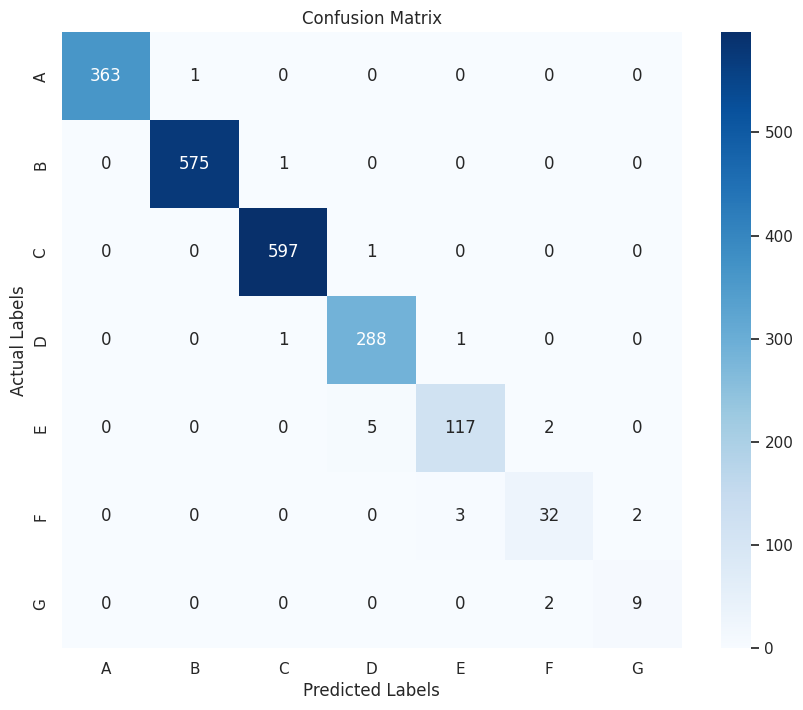

In [375]:
# plot confusion matrix
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
cm_gbm = confusion_matrix(y_test, y_pred_gbm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_gbm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

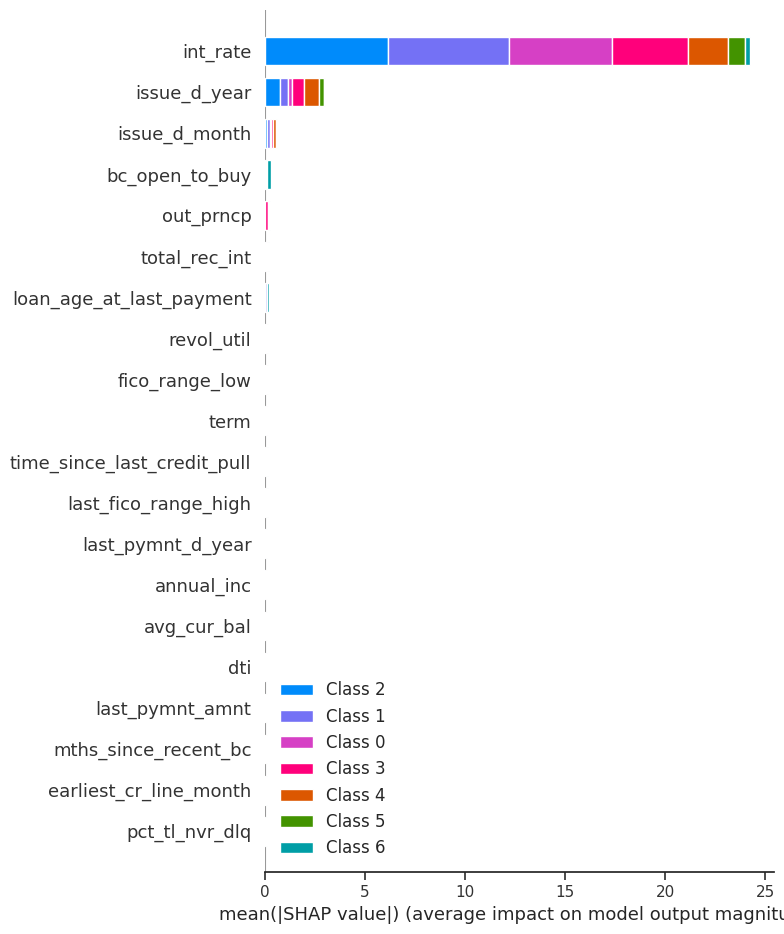

In [334]:
import shap
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
# Fine tunning
param_grids_gbm = [{'n_estimators': [400, 600, 1000]}
                   {'max_depth': [4,6,8],'num_leaves': [20,30,40],}, 
                   {'min_child_samples': [18,19,20,21,22],'min_child_weight': [0.001,0.002]},
                   {'feature_fraction': [0.6, 0.8, 1]}, 
                   {'bagging_fraction': [0.8,0.9,1],'bagging_freq': [2,3,4]}]


other_params_gbm = {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 6, 'min_child_samples':21, 'min_child_weight': 0.001,
                    'feature_fraction': 0.7, 'bagging_fraction': 1, 'bagging_freq': 2,'reg_alpha': 0.001, 'reg_lambda': 8}

GridSearch_gbm = optimize_parameters(LGBMClassifier, param_grids_gbm, other_params_gbm, X_train, y_train)
GridSearch_gbm['model'] = 'LGBMClassifier'

# Best params:
gbm_bestParams= [{'max_depth': 6, 'num_leaves': 20},
             {'min_child_samples': 19, 'min_child_weight': 0.001},
             {'feature_fraction': 0.8},
             {'bagging_fraction': 1, 'bagging_freq': 2}]

In [95]:
GridSearch_gbm

,model,best_params,f1_weighted
0,LGBMClassifier,"{'max_depth': 8, 'num_leaves': 20}",0.921489
1,LGBMClassifier,"{'min_child_samples': 18, 'min_child_weight': ...",0.920083
2,LGBMClassifier,{'feature_fraction': 1},0.922553
3,LGBMClassifier,"{'bagging_fraction': 1, 'bagging_freq': 2}",0.919684


In [ ]:
# with best params
gbm_bestParams = LGBMClassifier(objective = 'multiclass',
                     class_weight='balanced',
                      n_estimators=40,
                      is_unbalance = True,
                      max_depth = 8,
                      num_leaves = 40,
                      learning_rate = 0.1,
                      feature_fraction = 0.8,
                      min_child_samples=18,
                      min_child_weight=0.001,
                      bagging_fraction = 1,
                      bagging_freq = 2)
gbm_bestParams.fit(X_train, y_train, eval_set=[(X_test, y_test)])
y_pred_gbm_bestParams = gbm_bestParams.predict(X_test)
report_gbm_bestParams = classification_report(y_test, y_pred_gbm_bestParams)
macro_f1_score_gbm_bestParams, f1_score_gbm_bestParams,f1_GradeD_gbm_bestParams, f1_GradeE_gbm_bestParams, f1_GradeF_gbm_bestParams = get_metrics(report_gbm_bestParams)


In [336]:
print(report_gbm_bestParams)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      0.99      1.00       576
           2       0.99      1.00      1.00       598
           3       0.98      0.99      0.98       290
           4       0.96      0.93      0.94       124
           5       0.89      0.89      0.89        37
           6       0.91      0.91      0.91        11

    accuracy                           0.99      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.99      0.99      0.99      2000



In [345]:
# feature importance
gbm_impt=gbm_bestParams.feature_importances_
importance=pd.DataFrame({
    'column':X_train.columns,
    'importance':gbm_impt,
}).sort_values(by='importance')
importance=importance.reset_index(drop=True)
important_frt=list(importance['column'].values)
important_frt.reverse()

feature_select30 = important_frt[:30]
X_train_select = X_train[feature_select30]
X_test_select = X_test[feature_select30]

In [ ]:
# bestParams + feature selection
gbm_bestParams_select = LGBMClassifier(objective = 'multiclass',
                     class_weight='balanced',
                      n_estimators=40,
                      is_unbalance = True,
                      max_depth = 8,
                      num_leaves = 20,
                      learning_rate = 0.04,
                      feature_fraction = 0.8,
                      min_child_samples=18,
                      min_child_weight=0.001,
                      bagging_fraction = 1,
                      bagging_freq = 2)
gbm_bestParams_select.fit(X_train_select, y_train, eval_set=[(X_test_select, y_test)])
y_pred_gbm_bestParams_select = gbm_bestParams_select.predict(X_test_select)
report_gbm_bestParams_select = classification_report(y_test, y_pred_gbm_bestParams_select)
macro_f1_score_gbm_bestParams_select, f1_score_gbm_bestParams_select, f1_GradeD_gbm_bestParams_select, f1_GradeE_gbm_bestParams_select, f1_GradeF_gbm_bestParams_select = get_metrics(report_gbm_bestParams_select)

In [347]:
print(report_gbm_bestParams_select)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       364
           1       0.99      0.99      0.99       576
           2       0.99      0.99      0.99       598
           3       0.98      0.99      0.98       290
           4       0.96      0.93      0.94       124
           5       0.82      0.89      0.86        37
           6       0.80      0.73      0.76        11

    accuracy                           0.98      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.98      0.98      0.98      2000



### Model2 :  XGBoost

In [348]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
#report
report_xgb = classification_report(y_test, y_pred_xgb)
macro_f1_score_xgb, f1_score_xgb, f1_GradeD_xgb, f1_GradeE_xgb, f1_GradeF_xgb = get_metrics(report_xgb)

In [349]:
print(report_xgb)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       364
           1       0.99      1.00      0.99       576
           2       0.99      1.00      0.99       598
           3       0.98      0.99      0.98       290
           4       0.97      0.94      0.96       124
           5       0.80      0.89      0.85        37
           6       0.67      0.36      0.47        11

    accuracy                           0.99      2000
   macro avg       0.92      0.88      0.89      2000
weighted avg       0.99      0.99      0.99      2000



In [ ]:
param_grids = [{'n_estimators': [400, 500, 600]},
           {'max_depth': [4, 5, 6, 7, 8], 'min_child_weight': [1, 2, 3, 4]},
           {'gamma': [0.1, 0.2, 0.3, 0.4]},
           {'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
           {'reg_alpha': [0.05, 0.1, 1, 2], 'reg_lambda': [0.05, 0.1, 1, 2]},
           {'learning_rate': [0.01, 0.05, 0.07, 0.1]}]

other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 8, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

GridSearch_xgb = optimize_parameters(XGBClassifier, param_grids, other_params, X_train, y_train)

# best params:
xgb_bestParams= [{'n_estimators': 400},
                 {'max_depth': 8, 'min_child_weight': 1},
                 {'gamma': 0.4},
                 {'colsample_bytree': 0.9, 'subsample': 0.9},
                 {'reg_alpha': 0.05, 'reg_lambda': 0.1}	,
                 {'learning_rate': 0.01}]

In [ ]:
GridSearch_xgb

In [351]:
# with best params
xgb_bestParams = XGBClassifier(learning_rate=0.01, n_estimators = 400, max_depth = 9, min_child_weight= 1, seed= 0,
                    subsample= 0.8, colsample_bytree= 0.8, gamma= 0.6, reg_alpha= 0.05, reg_lambda = 0.05)
xgb_bestParams.fit(X_train, y_train)
y_pred_xgb_bestParams = xgb_bestParams.predict(X_test)

report_xgb_bestParams = classification_report(y_test, y_pred_xgb_bestParams)
macro_f1_score_xgb_bestParams, f1_score_xgb_bestParams, f1_GradeD_xgb_bestParams, f1_GradeE_xgb_bestParams, f1_GradeF_xgb_bestParams = get_metrics(report_xgb_bestParams)

In [352]:
print(report_xgb_bestParams)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       364
           1       0.99      0.99      0.99       576
           2       0.99      0.99      0.99       598
           3       0.97      0.99      0.98       290
           4       0.97      0.94      0.95       124
           5       0.79      0.92      0.85        37
           6       1.00      0.36      0.53        11

    accuracy                           0.98      2000
   macro avg       0.96      0.88      0.90      2000
weighted avg       0.98      0.98      0.98      2000



In [353]:
# feature importance
gbm_impt_xgb=xgb_bestParams.feature_importances_
importance=pd.DataFrame({
    'column':X_train.columns,
    'importance':gbm_impt_xgb,
}).sort_values(by='importance')
importance=importance.reset_index(drop=True)
important_frt=list(importance['column'].values)
important_frt.reverse()

feature_select20_xgb = important_frt[:20]
X_train_select_xgb = X_train[feature_select20_xgb]
X_test_select_xgb = X_test[feature_select20_xgb]

In [354]:
# Feature selection
xgb = XGBClassifier()
xgb.fit(X_train_select_xgb, y_train)
y_pred_xgb_select = xgb.predict(X_test_select_xgb)

report_xgb_select = classification_report(y_test, y_pred_xgb_select)
macro_f1_score_xgb_select, f1_score_xgb_select, f1_GradeD_xgb_select, f1_GradeE_xgb_select, f1_GradeF_xgb_select = get_metrics(report_xgb_select)

In [355]:
print(report_xgb_select)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       0.99      1.00      1.00       576
           2       1.00      0.99      0.99       598
           3       0.97      0.99      0.98       290
           4       0.97      0.95      0.96       124
           5       0.83      0.92      0.87        37
           6       0.83      0.45      0.59        11

    accuracy                           0.99      2000
   macro avg       0.94      0.90      0.91      2000
weighted avg       0.99      0.99      0.99      2000



In [356]:
# with best params + Feature selection
# Feature selection
xgb = XGBClassifier(learning_rate=0.01, n_estimators = 400, max_depth = 9, min_child_weight= 1, seed= 0,
                    subsample= 0.8, colsample_bytree= 0.8, gamma= 0.6, reg_alpha= 0.05, reg_lambda = 0.05)
xgb.fit(X_train_select_xgb, y_train)
y_pred_xgb_bestParams_select = xgb.predict(X_test_select_xgb)

report_xgb_bestParams_select = classification_report(y_test, y_pred_xgb_bestParams_select)
macro_f1_score_xgb_bestParams_select, f1_score_xgb_bestParams_select, f1_GradeD_xgb_bestParams_select, f1_GradeE_xgb_bestParams_select, f1_GradeF_xgb_bestParams_select = get_metrics(report_xgb_bestParams_select)

In [357]:
print(report_xgb_bestParams_select)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       364
           1       0.99      0.99      0.99       576
           2       0.99      0.99      0.99       598
           3       0.97      0.99      0.98       290
           4       0.97      0.94      0.95       124
           5       0.81      0.92      0.86        37
           6       0.83      0.45      0.59        11

    accuracy                           0.98      2000
   macro avg       0.94      0.90      0.91      2000
weighted avg       0.98      0.98      0.98      2000



### Model3 : MLP Model

In [358]:
mlp_clf = MLPClassifier(solver='lbfgs')
mlp_clf.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_clf.predict(X_test_scaled)

report_mlp = classification_report(y_test, y_pred_mlp)
macro_f1_score_mlp, f1_score_mlp, f1_GradeD_mlp, f1_GradeE_mlp, f1_GradeF_mlp = get_metrics(report_mlp)

In [359]:
print(report_mlp)

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       364
           1       0.91      0.90      0.90       576
           2       0.91      0.93      0.92       598
           3       0.85      0.86      0.85       290
           4       0.67      0.68      0.67       124
           5       0.41      0.32      0.36        37
           6       0.54      0.64      0.58        11

    accuracy                           0.88      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.88      0.88      0.88      2000



In [360]:
# parametres tunning
# mlp_200 = MLPClassifier(solver='lbfgs',hidden_layer_sizes=[200]) # f1 score: 0.68 / 0.82
# mlp_200 = MLPClassifier(solver='lbfgs',hidden_layer_sizes=[200,200]) # f1 score: 0.67 / 0.83
# mlp_200 = MLPClassifier(solver='lbfgs',hidden_layer_sizes=[200,200], activation='tanh') # f1 score: 0.7 / 0.83
mlp_tuned = MLPClassifier(solver='lbfgs',hidden_layer_sizes=[200,200], activation='tanh', alpha = 1, random_state=0) # f1 score: 0.72 / 0.85

mlp_tuned.fit(X_train_scaled,y_train)
y_pred_mlp_tuned = mlp_tuned.predict(X_test_scaled)
report_mlp_tuned = classification_report(y_test, y_pred_mlp_tuned)
macro_f1_score_mlp_tuned, f1_score_mlp_tuned,f1_GradeD_mlp_tuned, f1_GradeE_mlp_tuned, f1_GradeF_mlp_tuned = get_metrics(report_mlp_tuned)

In [361]:
print(report_mlp_tuned)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       364
           1       0.95      0.94      0.94       576
           2       0.95      0.97      0.96       598
           3       0.89      0.90      0.90       290
           4       0.77      0.77      0.77       124
           5       0.65      0.59      0.62        37
           6       0.67      0.36      0.47        11

    accuracy                           0.93      2000
   macro avg       0.83      0.78      0.80      2000
weighted avg       0.92      0.93      0.92      2000



## Comparing Models Prerformance

In [362]:
roc_auc_score_gbm = roc_auc_score(y_test, gbm_bestParams.predict_proba(X_test), multi_class='ovo', average = 'macro')
roc_auc_score_xgb = roc_auc_score(y_test, xgb_bestParams.predict_proba(X_test), multi_class='ovo', average = 'macro')
roc_auc_score_mlp = roc_auc_score(y_test, mlp_tuned.predict_proba(X_test_scaled), multi_class='ovo', average = 'macro')

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [363]:
data_performance = {
    'Model': ['LightGBM', 'XGBoost', 'MLP' ],
    'ROC_AUC': [roc_auc_score_gbm,roc_auc_score_xgb, roc_auc_score_mlp],
    'Macro_f1_score': [macro_f1_score_gbm_bestParams_select,macro_f1_score_xgb_bestParams_select, macro_f1_score_mlp_tuned],
    'Weighted_f1_score': [f1_score_gbm_bestParams, f1_score_xgb_bestParams_select, f1_score_mlp_tuned],
    'f1_Grade_D': [f1_GradeD_gbm_bestParams, f1_GradeD_xgb, f1_GradeD_mlp_tuned],
    'f1_Grade_E': [f1_GradeE_gbm_bestParams, f1_GradeE_xgb,f1_GradeE_mlp_tuned],
    'f1_Grade_F': [f1_GradeF_gbm_bestParams, f1_GradeF_xgb,f1_GradeF_mlp_tuned]
    }

data_performance = pd.DataFrame(data_performance)
data_performance
# the table showing the performance metrics for each model separately.

,Model,ROC_AUC,Macro_f1_score,Weighted_f1_score,f1_Grade_D,f1_Grade_E,f1_Grade_F
0,LightGBM,0.997977,0.95,0.99,0.98,0.94,0.89
1,XGBoost,0.990776,0.95,0.98,0.98,0.96,0.85
2,MLP,0.973679,0.95,0.92,0.90,0.77,0.62


Overall, the model LightGBM is performing well accoding to the weighted f1 score and ROC_AUC score.

LightGBM outperforms the other models in terms of ROC AUC (0.99), suggesting its better ability to classify positive and negative instances.
It demonstrates the highest weighted F1 score (0.95) among the three models, indicating its overall better performance. Also it achieves a relatively high F1 score for Minority Class D, E, F, making it more reliable for predicting this specific minority class.

However, with a significant class imbalance among the 7 classes, the high ROC AUC score may not reflect the model's performance accurately, considering the f1 score is not as high as ROC AUC score. The majority classes dominates the ROC AUC calculation, while the model's performance on minority classes is relatively poor, leading to lower F1 scores.

By examining the weighted F1 scores for class D,E, and F, these three classes are particularly difficult for the model to predict accurately, and the model is struggling to capture all positive instances or is incorrectly predicting samples as positive for these classes.

In [368]:
data_gbm = {
    'Model': ['LightGBM', 'LightGBM_Finetune', 'LightGBM_FeatureSelect', 'LightGBM_Finetune_FeatureSelect'],
    'Macro_f1_score':[macro_f1_score_gbm, macro_f1_score_gbm_bestParams, macro_f1_score_gbm_select, macro_f1_score_gbm_bestParams_select],
    'Weighted_f1_score': [f1_score_gbm, f1_score_gbm_bestParams, f1_score_gbm_select, f1_score_gbm_bestParams_select],
    'f1_Grade_D': [f1_GradeD_gbm, f1_GradeD_gbm_bestParams, f1_GradeD_gbm_select,f1_GradeD_gbm_bestParams_select],
    'f1_Grade_E': [f1_GradeE_gbm, f1_GradeE_gbm_bestParams, f1_GradeE_gbm_select,f1_GradeE_gbm_bestParams_select],
    'f1_Grade_F': [f1_GradeF_gbm, f1_GradeF_gbm_bestParams, f1_GradeF_gbm_select,f1_GradeF_gbm_bestParams_select]
    }
data_gbm = pd.DataFrame(data_gbm)
data_gbm

,Model,Macro_f1_score,Weighted_f1_score,f1_Grade_D,f1_Grade_E,f1_Grade_F
0,LightGBM,0.95,0.99,0.99,0.96,0.88
1,LightGBM_Finetune,0.95,0.99,0.98,0.94,0.89
2,LightGBM_FeatureSelect,0.95,0.99,0.99,0.96,0.87
3,LightGBM_Finetune_FeatureSelect,0.95,0.98,0.98,0.94,0.86


Model improvements: as there are significant class imbalances where certain classes have lower weighted F1 scores, so we wre considering techniques such as class weighting, oversampling/undersampling to improve the performance of the model on those challenging classes.